In [5]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Modeling Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, regularizers, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Flatten, Input, Dropout, 
                                     Add, BatchNormalization, Activation, 
                                     Conv2D, MaxPooling2D)

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             accuracy_score, precision_score)
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import sys
sys.path.append(os.path.join(os.pardir, os.pardir, 'src'))
import functions as fx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
train_path = os.path.join(os.pardir, os.pardir, 'data', 'train')
test_path = os.path.join(os.pardir, os.pardir, 'data', 'test')

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30, zoom_range = 0.3,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   horizontal_flip = True, brightness_range = [0.5, 1.5], 
                                   validation_split = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (64, 64), 
    batch_size = 32, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'training')
val_generator = val_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (64, 64),
    batch_size = 32, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'validation')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (64, 64), 
                         batch_size = 32, class_mode = 'binary', 
                         classes = ['perennials', 'weeds'])

Found 4698 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


In [7]:
# Calculate weights to balance perennial and weed data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

# Stop training if training accuracy does not decrease in 5 epochs
early_stop_loss = EarlyStopping(monitor = 'accuracy', patience = 10, restore_best_weights = True)

In [8]:
def reduced_1(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [9]:
reduced_1_model = reduced_1(train_generator[0][0][0])
reduced_1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          5

2021-12-26 05:06:39.754995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
reduced_1_result = reduced_1_model.fit(train_generator, epochs = 75, validation_data=val_generator,
                                       class_weight = train_class_weights, callbacks = [early_stop_loss],
                                       verbose = 0)

2021-12-26 05:06:45.223426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


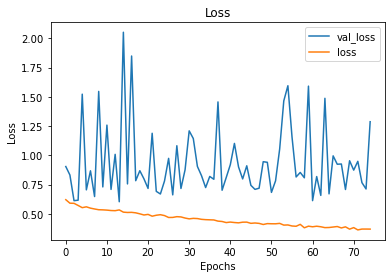

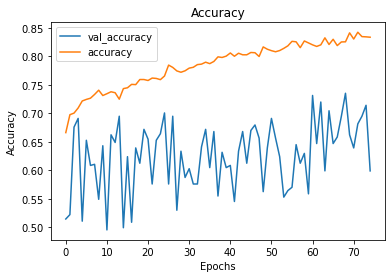

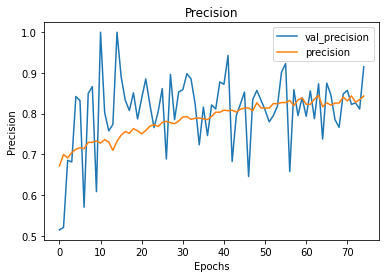

In [11]:
fx.visualize_training_results(reduced_1_result, 'reduced_1')

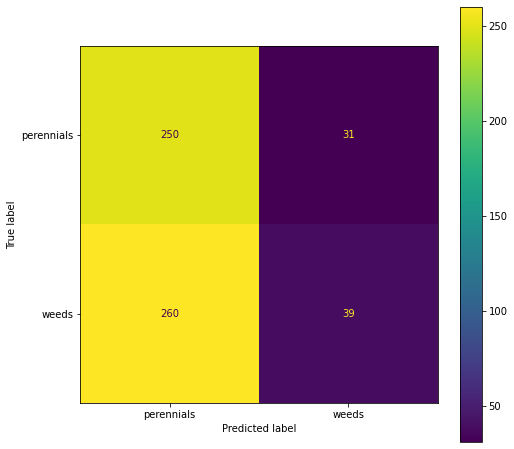

In [12]:
fx.create_confusion_matrix(reduced_1_model, test_generator, 'reduced_1')

In [13]:
fx.get_metrics(reduced_1_model, test_generator)

Accuracy: 0.5051724137931034
Precision: 0.5857142857142857


  0%|          | 0/1000 [00:00<?, ?it/s]

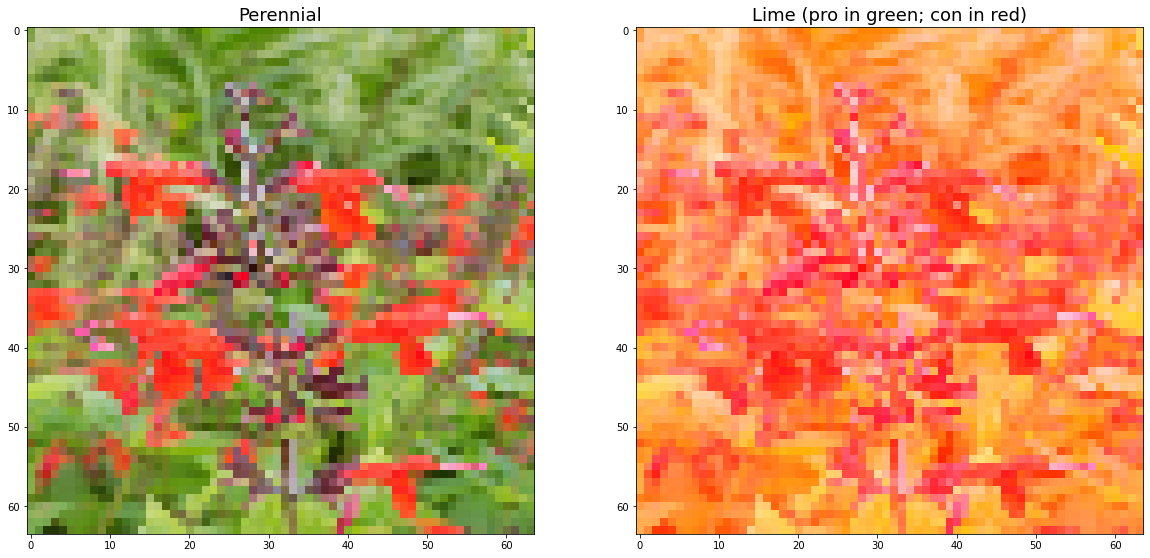

  0%|          | 0/1000 [00:00<?, ?it/s]

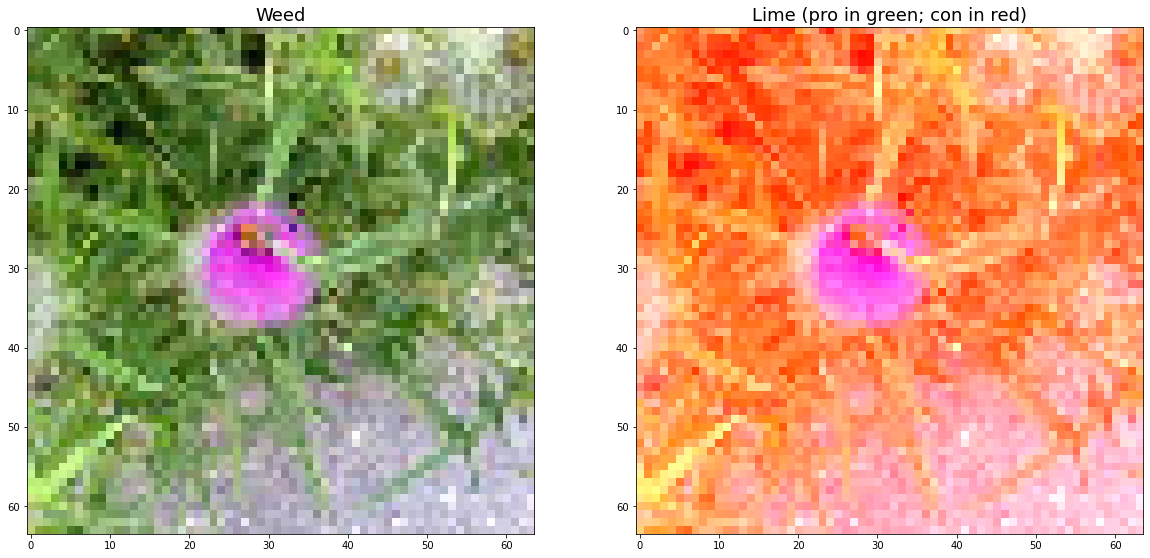

In [14]:
fx.display_lime(reduced_1_model, test_generator, 'reduced_1')

In [15]:
train_path = os.path.join(os.pardir, os.pardir, 'data', 'train')
test_path = os.path.join(os.pardir, os.pardir, 'data', 'test')

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30, zoom_range = 0.3,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   horizontal_flip = True, brightness_range = [0.5, 1.5], 
                                   validation_split = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (128, 128), 
    batch_size = 32, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'training')
val_generator = val_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (128, 128),
    batch_size = 32, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'validation')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (128, 128), 
                         batch_size = 32, class_mode = 'binary', 
                         classes = ['perennials', 'weeds'])

Found 4698 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


In [16]:
def reduced_2(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [17]:
reduced_2_model = reduced_2(train_generator[0][0][0])
reduced_2_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 16)        64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)       

In [18]:
reduced_2_result = reduced_2_model.fit(train_generator, epochs = 75, validation_data=val_generator,
                                       class_weight = train_class_weights, callbacks = [early_stop_loss],
                                       verbose = 0)

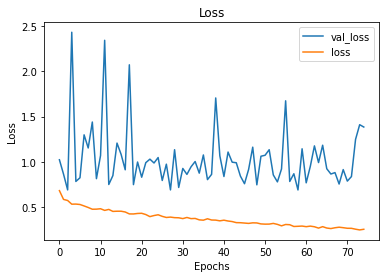

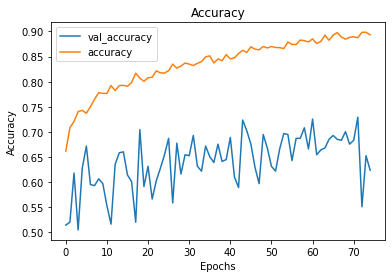

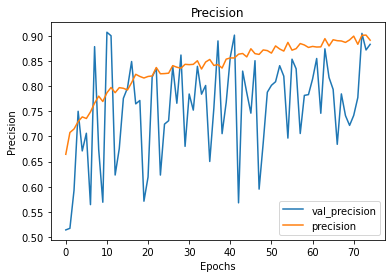

In [19]:
fx.visualize_training_results(reduced_2_result, 'reduced_2')

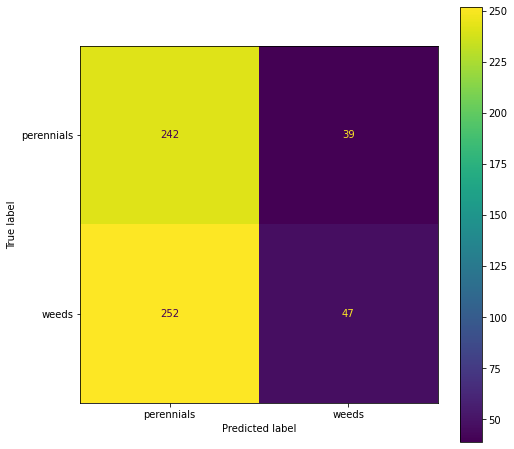

In [20]:
fx.create_confusion_matrix(reduced_2_model, test_generator, 'reduced_2')

In [21]:
fx.get_metrics(reduced_2_model, test_generator)

Accuracy: 0.4879310344827586
Precision: 0.5116279069767442


  0%|          | 0/1000 [00:00<?, ?it/s]

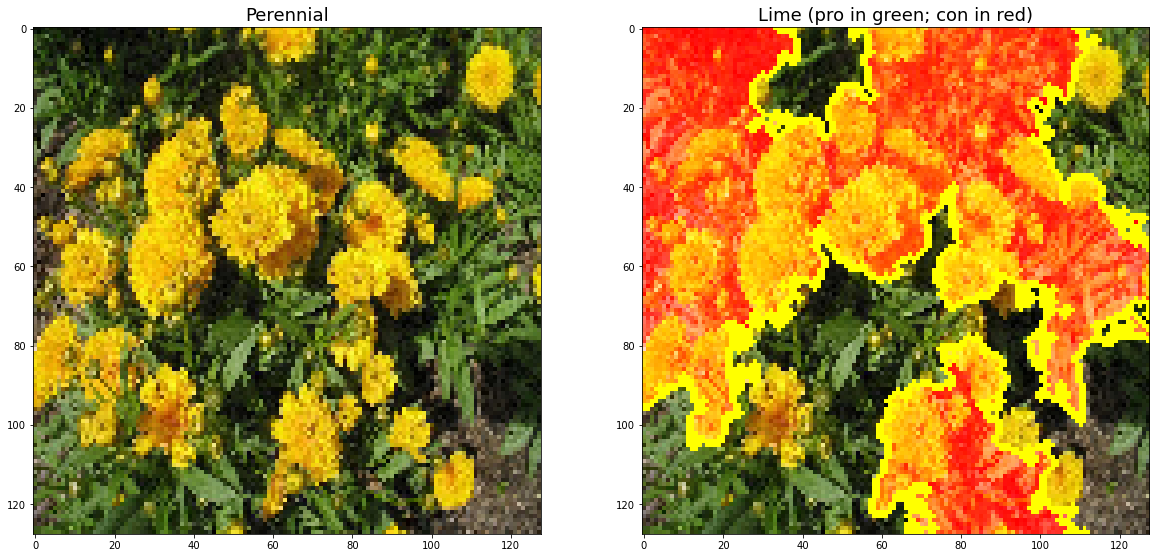

  0%|          | 0/1000 [00:00<?, ?it/s]

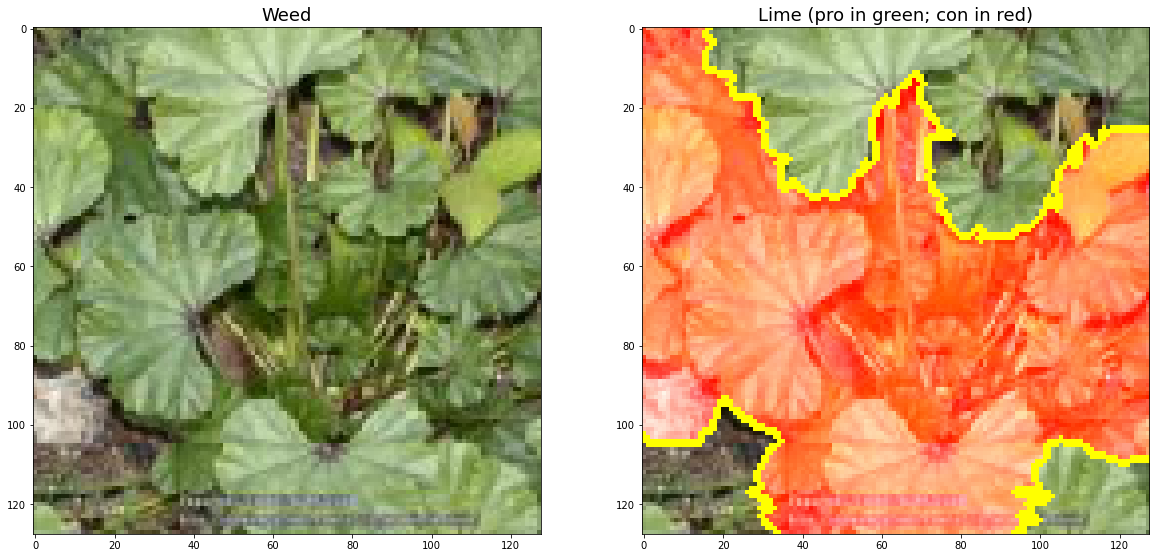

In [22]:
fx.display_lime(reduced_2_model, test_generator, 'reduced_2')

In [23]:
train_path = os.path.join(os.pardir, os.pardir, 'data', 'train')
test_path = os.path.join(os.pardir, os.pardir, 'data', 'test')

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30, zoom_range = 0.3,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   horizontal_flip = True, brightness_range = [0.5, 1.5], 
                                   validation_split = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (512, 512), 
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'training')
val_generator = val_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (512, 512),
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'validation')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (512, 512), 
                         batch_size = 64, class_mode = 'binary', 
                         classes = ['perennials', 'weeds'])

Found 4698 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


In [24]:
def reduced_3(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [25]:
reduced_3_model = reduced_3(train_generator[0][0][0])
reduced_3_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 508, 508, 16)      1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 254, 254, 16)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 254, 254, 16)      64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 250, 250, 32)      12832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 121, 121, 64)     

In [26]:
reduced_3_result = reduced_3_model.fit(train_generator, epochs = 75, validation_data=val_generator,
                                       class_weight = train_class_weights, callbacks = [early_stop_loss],
                                       verbose = 0)

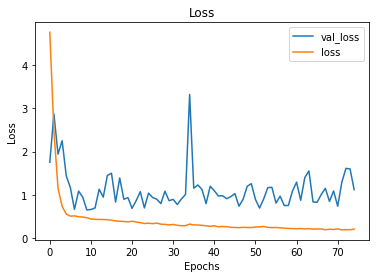

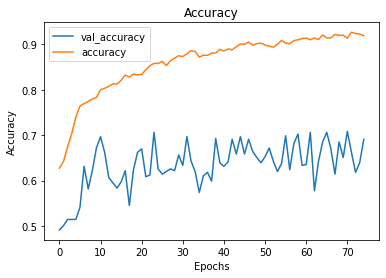

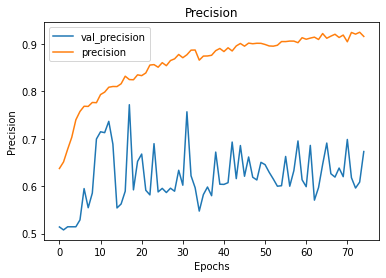

In [27]:
fx.visualize_training_results(reduced_3_result, 'reduced_3')

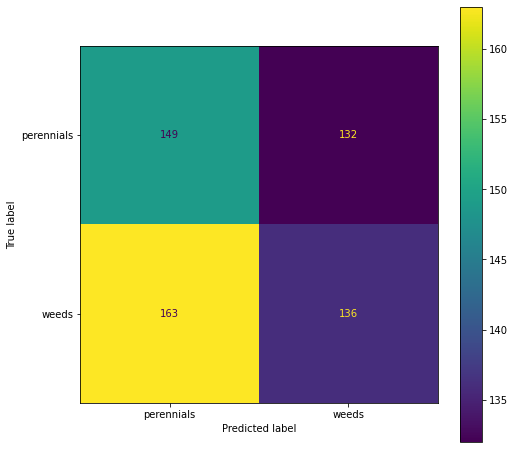

In [28]:
fx.create_confusion_matrix(reduced_3_model, test_generator, 'reduced_3')

In [29]:
fx.get_metrics(reduced_3_model, test_generator)

Accuracy: 0.5431034482758621
Precision: 0.5634328358208955


  0%|          | 0/1000 [00:00<?, ?it/s]

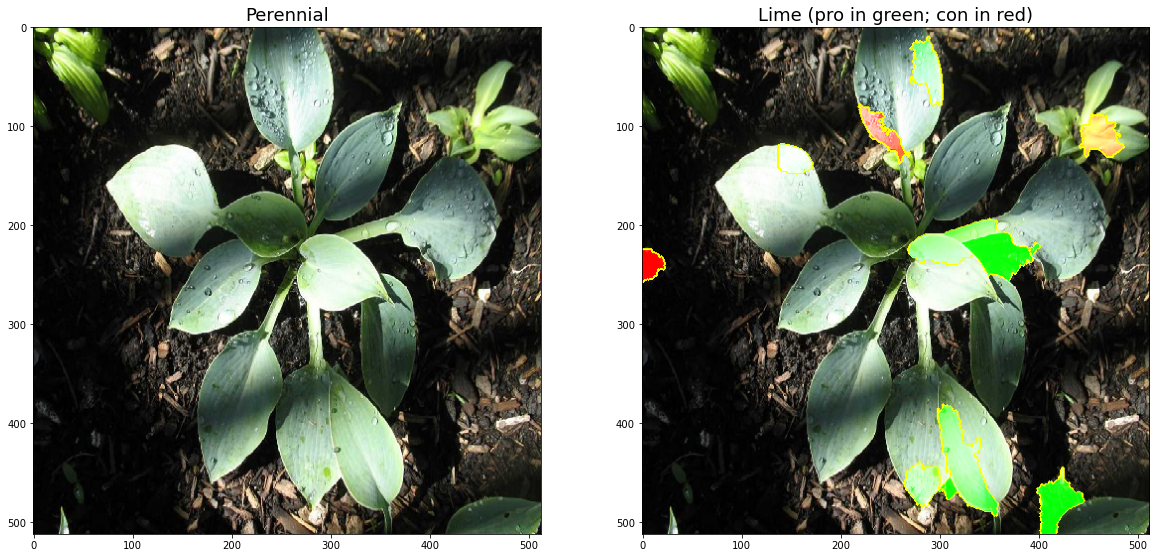

  0%|          | 0/1000 [00:00<?, ?it/s]

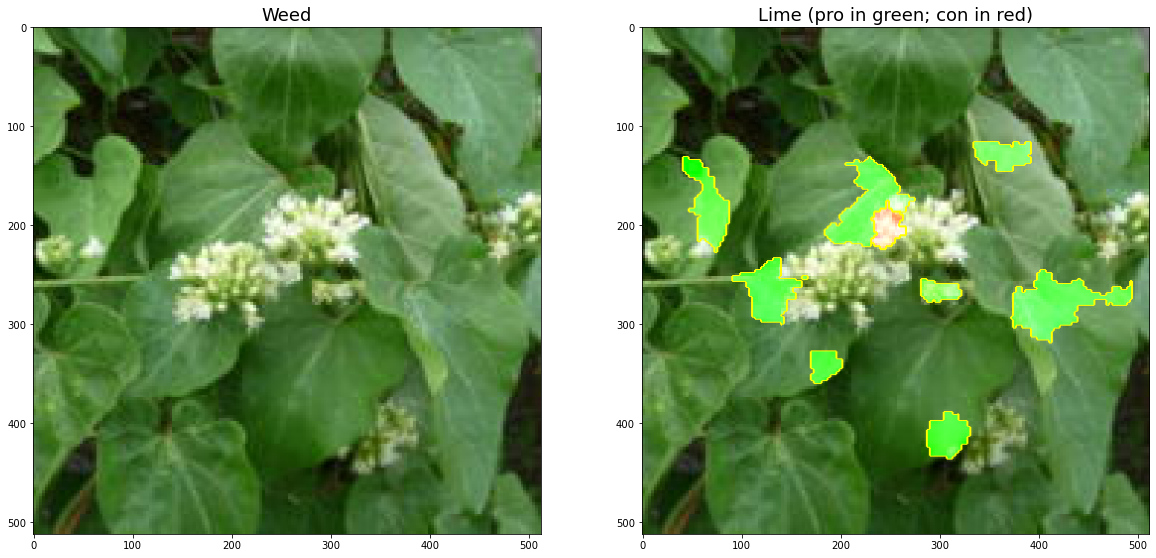

In [30]:
fx.display_lime(reduced_3_model, test_generator, 'reduced_3')

In [ ]:
fx.visualize_training_results(reduced_3_result, 'reduced_3')
fx.create_confusion_matrix(reduced_3_model, test_generator, 'reduced_3')
fx.get_metrics(reduced_3_model, test_generator)
fx.display_lime(reduced_3_model, test_generator, 'reduced_3')

In [ ]:
def reduced_2(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)),
        Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model